<a href="https://colab.research.google.com/github/salsabillaflsft/ABSApublic/blob/main/mono_AspectBasedSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aspect Based Sentiment Analysis
BERT - IndoBERT

## Installation

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00


## Import Libraries

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from transformers import BertTokenizer, BertConfig, BertForPreTraining, BertPreTrainedModel, BertModel

import itertools
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

## Preparation

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(26092020)

## Bert Module


In [ ]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels_list
        self.bert = BertModel(config)
        # self.dropout = nn.Dropout(config.hidden_dropout_prob) #0.1
        self.dropout = nn.Dropout(p=0.5)
        self.classifiers = nn.ModuleList([nn.Linear(config.hidden_size, num_label) for num_label in self.num_labels])

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        subword_to_word_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = self.dropout(outputs[1])
        logits = []
        for classifier in self.classifiers:
            logit = classifier(sequence_output)
            logits.append(logit)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            total_loss = 0
            for i, (logit, num_label) in enumerate(zip(logits, self.num_labels)):
                label = labels[:,i]
                loss = loss_fct(logit.view(-1, num_label), label.view(-1))
                total_loss += loss
            outputs = (total_loss,) + outputs

        return outputs  # (loss), scores, (hidden_states), (attentions)

## Utils

### Dataset

In [ ]:
class AspectBasedSentimentAnalysisDataset(Dataset):
    # Static constant variable
    ASPECT_DOMAIN = ['umum','layanan','menu','harga','fasilitas','suasana']
    LABEL2INDEX = {'none': 0, 'negative': 1, 'positive':2, 'neutral': 3}
    INDEX2LABEL = { 0:'none', 1:'negative', 2: 'positive', 3: 'neutral'}
    NUM_LABELS = [4, 4, 4, 4, 4, 4]
    NUM_ASPECTS = 6

    def load_dataset(self, path):
        df = pd.read_csv(path)
        for aspect in self.ASPECT_DOMAIN:
            df[aspect] = df[aspect].apply(lambda sen: self.LABEL2INDEX[sen])
        return df

    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index,:]
        sentence, labels = data['review_text'], [data[aspect] for aspect in self.ASPECT_DOMAIN]
        subwords = self.tokenizer.encode(sentence, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['review_text']

    def __len__(self):
        return len(self.data)

class AspectBasedSentimentAnalysisDataLoader(DataLoader):
    def __init__(self, dataset, max_seq_len=512, *args, **kwargs):
        super(AspectBasedSentimentAnalysisDataLoader, self).__init__(dataset=dataset, *args, **kwargs)
        self.num_aspects = dataset.NUM_ASPECTS
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        label_batch = np.zeros((batch_size, self.num_aspects), dtype=np.int64)

        seq_list = []

        for i, (subwords, label, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            label_batch[i,:] = label

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, label_batch, seq_list

### Forward fn

In [ ]:
# Forward function for sequence multilabel classification
def forward_sequence_multi_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2] # logits list<tensor(bs, num_label)> ~ list of batch prediction per class

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = [torch.topk(logit, 1)[1] for logit in logits] # list<tensor(bs)>
    batch_size = label_batch.shape[0]
    num_label = len(hyp)
    for i in range(batch_size):
        hyps = []
        labels = label_batch[i,:].cpu().numpy().tolist()
        for j in range(num_label):
            hyps.append(hyp[j][i].item())
        list_hyp.append([i2w[hyp] for hyp in hyps])
        list_label.append([i2w[label] for label in labels])

    return loss, list_hyp, list_label

### ABSA metrics

In [ ]:
def absa_metrics_fn(list_hyp, list_label):
    # hyp and label are both list (multi label), flatten the list
    list_hyp = list(itertools.chain.from_iterable(list_hyp))
    list_label = list(itertools.chain.from_iterable(list_label))

    metrics = {}
    metrics["ACCURACY"] = accuracy_score(list_label, list_hyp)
    metrics["PRECISION"] = precision_score(list_label, list_hyp, average='macro', zero_division=1)
    metrics["RECALL"] = recall_score(list_label, list_hyp, average='macro')
    metrics["F1-SCORE"] = f1_score(list_label, list_hyp, average='macro')
    return metrics

    # metrics["PRECISION"] = precision_score(list_label, list_hyp, average='macro', zero_division=0)
    # metrics["RECALL"] = recall_score(list_label, list_hyp, average='macro', zero_division=0)
    # metrics["F1-SCORE"] = f1_score(list_label, list_hyp, average='macro', zero_division=0)

## Load Tokenizer, Config, Model

In [ ]:
# Load Tokenizer, Config, Model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')

config.num_labels = max(AspectBasedSentimentAnalysisDataset.NUM_LABELS)
config.num_labels_list = AspectBasedSentimentAnalysisDataset.NUM_LABELS
model = BertForMultiLabelClassification.from_pretrained('indobenchmark/indobert-base-p1',config=config)

Some weights of BertForMultiLabelClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifiers.0.bias', 'classifiers.1.bias', 'classifiers.4.weight', 'classifiers.2.bias', 'classifiers.3.weight', 'classifiers.2.weight', 'classifiers.1.weight', 'classifiers.5.weight', 'classifiers.5.bias', 'classifiers.4.bias', 'classifiers.3.bias', 'classifiers.0.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
count_param(model)

124459800

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/TA/Dataset

Mounted at /content/drive
/content/drive/My Drive/TA/Dataset


In [ ]:
dataset_folder_path = '/content/drive/MyDrive//TA/Dataset'

In [ ]:
train_dataset_path = dataset_folder_path + '/train_set.csv'
valid_dataset_path = dataset_folder_path + '/val_set.csv'
test_dataset_path = dataset_folder_path + '/test_set.csv'

In [ ]:
train_dataset = AspectBasedSentimentAnalysisDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = AspectBasedSentimentAnalysisDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = AspectBasedSentimentAnalysisDataset(test_dataset_path, tokenizer, lowercase=True)

batch size

In [ ]:
train_loader = AspectBasedSentimentAnalysisDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=16, shuffle=True)
valid_loader = AspectBasedSentimentAnalysisDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=16, shuffle=False)
test_loader = AspectBasedSentimentAnalysisDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=16, shuffle=False)

In [ ]:
w2i, i2w = AspectBasedSentimentAnalysisDataset.LABEL2INDEX, AspectBasedSentimentAnalysisDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'none': 0, 'negative': 1, 'positive': 2, 'neutral': 3}
{0: 'none', 1: 'negative', 2: 'positive', 3: 'neutral'}


## Modelling

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-5)
model = model.cuda()

In [ ]:
model

BertForMultiLabelClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 3e-05
    maximize: False
    weight_decay: 0
)

### Training

epoch

(Epoch 1) TRAIN LOSS:3.7516 LR:0.00003000: 100%|██████████| 113/113 [00:42<00:00,  2.64it/s]


(Epoch 1) TRAIN LOSS:3.7516 ACCURACY:0.79 PRECISION:0.54 RECALL:0.46 F1-SCORE:0.46 LR:0.00003000


VALID LOSS:2.4506 ACCURACY:0.85 PRECISION:0.88 RECALL:0.53 F1-SCORE:0.54: 100%|██████████| 25/25 [00:02<00:00,  8.55it/s]


(Epoch 1) VALID LOSS:2.4506 ACCURACY:0.85 PRECISION:0.88 RECALL:0.53 F1-SCORE:0.54


(Epoch 2) TRAIN LOSS:2.0600 LR:0.00003000: 100%|██████████| 113/113 [00:41<00:00,  2.69it/s]


(Epoch 2) TRAIN LOSS:2.0600 ACCURACY:0.89 PRECISION:0.73 RECALL:0.59 F1-SCORE:0.62 LR:0.00003000


VALID LOSS:1.9739 ACCURACY:0.89 PRECISION:0.71 RECALL:0.67 F1-SCORE:0.67: 100%|██████████| 25/25 [00:03<00:00,  8.14it/s]


(Epoch 2) VALID LOSS:1.9739 ACCURACY:0.89 PRECISION:0.71 RECALL:0.67 F1-SCORE:0.67


(Epoch 3) TRAIN LOSS:1.4907 LR:0.00003000: 100%|██████████| 113/113 [00:43<00:00,  2.60it/s]


(Epoch 3) TRAIN LOSS:1.4907 ACCURACY:0.92 PRECISION:0.81 RECALL:0.69 F1-SCORE:0.73 LR:0.00003000


VALID LOSS:1.7085 ACCURACY:0.91 PRECISION:0.81 RECALL:0.67 F1-SCORE:0.71: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


(Epoch 3) VALID LOSS:1.7085 ACCURACY:0.91 PRECISION:0.81 RECALL:0.67 F1-SCORE:0.71


(Epoch 4) TRAIN LOSS:1.1321 LR:0.00003000: 100%|██████████| 113/113 [00:42<00:00,  2.65it/s]


(Epoch 4) TRAIN LOSS:1.1321 ACCURACY:0.94 PRECISION:0.84 RECALL:0.74 F1-SCORE:0.77 LR:0.00003000


VALID LOSS:1.5980 ACCURACY:0.91 PRECISION:0.76 RECALL:0.70 F1-SCORE:0.70: 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


(Epoch 4) VALID LOSS:1.5980 ACCURACY:0.91 PRECISION:0.76 RECALL:0.70 F1-SCORE:0.70


(Epoch 5) TRAIN LOSS:0.8856 LR:0.00003000: 100%|██████████| 113/113 [00:43<00:00,  2.59it/s]


(Epoch 5) TRAIN LOSS:0.8856 ACCURACY:0.96 PRECISION:0.89 RECALL:0.79 F1-SCORE:0.83 LR:0.00003000


VALID LOSS:1.6032 ACCURACY:0.91 PRECISION:0.78 RECALL:0.73 F1-SCORE:0.75: 100%|██████████| 25/25 [00:03<00:00,  7.76it/s]


(Epoch 5) VALID LOSS:1.6032 ACCURACY:0.91 PRECISION:0.78 RECALL:0.73 F1-SCORE:0.75


(Epoch 6) TRAIN LOSS:0.7115 LR:0.00003000: 100%|██████████| 113/113 [00:42<00:00,  2.65it/s]


(Epoch 6) TRAIN LOSS:0.7115 ACCURACY:0.97 PRECISION:0.92 RECALL:0.84 F1-SCORE:0.87 LR:0.00003000


VALID LOSS:1.5720 ACCURACY:0.91 PRECISION:0.77 RECALL:0.71 F1-SCORE:0.74: 100%|██████████| 25/25 [00:03<00:00,  8.17it/s]


(Epoch 6) VALID LOSS:1.5720 ACCURACY:0.91 PRECISION:0.77 RECALL:0.71 F1-SCORE:0.74


(Epoch 7) TRAIN LOSS:0.5727 LR:0.00003000: 100%|██████████| 113/113 [00:42<00:00,  2.68it/s]


(Epoch 7) TRAIN LOSS:0.5727 ACCURACY:0.98 PRECISION:0.93 RECALL:0.88 F1-SCORE:0.90 LR:0.00003000


VALID LOSS:1.5352 ACCURACY:0.92 PRECISION:0.81 RECALL:0.74 F1-SCORE:0.77: 100%|██████████| 25/25 [00:03<00:00,  8.12it/s]


(Epoch 7) VALID LOSS:1.5352 ACCURACY:0.92 PRECISION:0.81 RECALL:0.74 F1-SCORE:0.77


(Epoch 8) TRAIN LOSS:0.4416 LR:0.00003000: 100%|██████████| 113/113 [00:42<00:00,  2.63it/s]


(Epoch 8) TRAIN LOSS:0.4416 ACCURACY:0.99 PRECISION:0.96 RECALL:0.91 F1-SCORE:0.93 LR:0.00003000


VALID LOSS:1.5302 ACCURACY:0.92 PRECISION:0.80 RECALL:0.73 F1-SCORE:0.76: 100%|██████████| 25/25 [00:03<00:00,  8.11it/s]


(Epoch 8) VALID LOSS:1.5302 ACCURACY:0.92 PRECISION:0.80 RECALL:0.73 F1-SCORE:0.76


(Epoch 9) TRAIN LOSS:0.3568 LR:0.00003000: 100%|██████████| 113/113 [00:41<00:00,  2.70it/s]


(Epoch 9) TRAIN LOSS:0.3568 ACCURACY:0.99 PRECISION:0.98 RECALL:0.95 F1-SCORE:0.96 LR:0.00003000


VALID LOSS:1.4714 ACCURACY:0.92 PRECISION:0.80 RECALL:0.76 F1-SCORE:0.77: 100%|██████████| 25/25 [00:03<00:00,  8.14it/s]


(Epoch 9) VALID LOSS:1.4714 ACCURACY:0.92 PRECISION:0.80 RECALL:0.76 F1-SCORE:0.77


(Epoch 10) TRAIN LOSS:0.2828 LR:0.00003000: 100%|██████████| 113/113 [00:42<00:00,  2.68it/s]


(Epoch 10) TRAIN LOSS:0.2828 ACCURACY:0.99 PRECISION:0.98 RECALL:0.96 F1-SCORE:0.97 LR:0.00003000


VALID LOSS:1.4853 ACCURACY:0.92 PRECISION:0.79 RECALL:0.76 F1-SCORE:0.77: 100%|██████████| 25/25 [00:03<00:00,  8.15it/s]


(Epoch 10) VALID LOSS:1.4853 ACCURACY:0.92 PRECISION:0.79 RECALL:0.76 F1-SCORE:0.77


(Epoch 11) TRAIN LOSS:0.2262 LR:0.00003000: 100%|██████████| 113/113 [00:43<00:00,  2.59it/s]


(Epoch 11) TRAIN LOSS:0.2262 ACCURACY:1.00 PRECISION:0.99 RECALL:0.98 F1-SCORE:0.98 LR:0.00003000


VALID LOSS:1.6558 ACCURACY:0.91 PRECISION:0.77 RECALL:0.75 F1-SCORE:0.76: 100%|██████████| 25/25 [00:03<00:00,  8.14it/s]


(Epoch 11) VALID LOSS:1.6558 ACCURACY:0.91 PRECISION:0.77 RECALL:0.75 F1-SCORE:0.76


(Epoch 12) TRAIN LOSS:0.1937 LR:0.00003000: 100%|██████████| 113/113 [00:43<00:00,  2.60it/s]


(Epoch 12) TRAIN LOSS:0.1937 ACCURACY:1.00 PRECISION:0.99 RECALL:0.98 F1-SCORE:0.99 LR:0.00003000


VALID LOSS:1.5392 ACCURACY:0.92 PRECISION:0.79 RECALL:0.75 F1-SCORE:0.77: 100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


(Epoch 12) VALID LOSS:1.5392 ACCURACY:0.92 PRECISION:0.79 RECALL:0.75 F1-SCORE:0.77


(Epoch 13) TRAIN LOSS:0.1554 LR:0.00003000: 100%|██████████| 113/113 [00:43<00:00,  2.60it/s]


(Epoch 13) TRAIN LOSS:0.1554 ACCURACY:1.00 PRECISION:1.00 RECALL:0.99 F1-SCORE:0.99 LR:0.00003000


VALID LOSS:1.5816 ACCURACY:0.92 PRECISION:0.78 RECALL:0.77 F1-SCORE:0.77: 100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


(Epoch 13) VALID LOSS:1.5816 ACCURACY:0.92 PRECISION:0.78 RECALL:0.77 F1-SCORE:0.77


(Epoch 14) TRAIN LOSS:0.1347 LR:0.00003000: 100%|██████████| 113/113 [00:43<00:00,  2.62it/s]


(Epoch 14) TRAIN LOSS:0.1347 ACCURACY:1.00 PRECISION:1.00 RECALL:0.99 F1-SCORE:1.00 LR:0.00003000


VALID LOSS:1.5789 ACCURACY:0.92 PRECISION:0.80 RECALL:0.73 F1-SCORE:0.76: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


(Epoch 14) VALID LOSS:1.5789 ACCURACY:0.92 PRECISION:0.80 RECALL:0.73 F1-SCORE:0.76


(Epoch 15) TRAIN LOSS:0.1219 LR:0.00003000: 100%|██████████| 113/113 [00:43<00:00,  2.60it/s]


(Epoch 15) TRAIN LOSS:0.1219 ACCURACY:1.00 PRECISION:1.00 RECALL:0.99 F1-SCORE:1.00 LR:0.00003000


VALID LOSS:1.6607 ACCURACY:0.92 PRECISION:0.79 RECALL:0.73 F1-SCORE:0.76: 100%|██████████| 25/25 [00:03<00:00,  8.13it/s]


(Epoch 15) VALID LOSS:1.6607 ACCURACY:0.92 PRECISION:0.79 RECALL:0.73 F1-SCORE:0.76


(Epoch 16) TRAIN LOSS:0.1033 LR:0.00003000: 100%|██████████| 113/113 [00:43<00:00,  2.59it/s]


(Epoch 16) TRAIN LOSS:0.1033 ACCURACY:1.00 PRECISION:1.00 RECALL:1.00 F1-SCORE:1.00 LR:0.00003000


VALID LOSS:1.6150 ACCURACY:0.92 PRECISION:0.80 RECALL:0.76 F1-SCORE:0.77: 100%|██████████| 25/25 [00:03<00:00,  8.12it/s]


(Epoch 16) VALID LOSS:1.6150 ACCURACY:0.92 PRECISION:0.80 RECALL:0.76 F1-SCORE:0.77


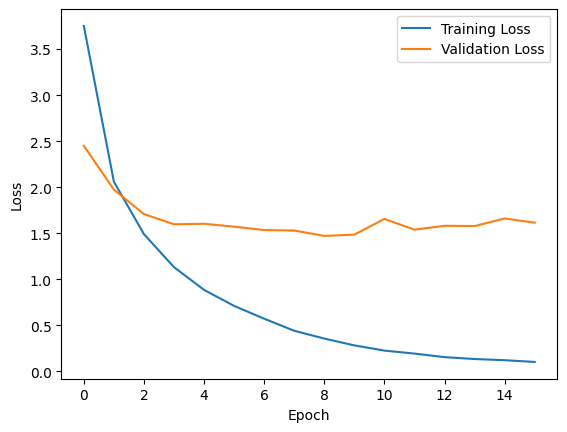

In [ ]:
import matplotlib.pyplot as plt

# Train
n_epochs = 16
train_losses, valid_losses = [], []

for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = absa_metrics_fn(list_hyp, list_label)
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        train_loss, metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = absa_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = absa_metrics_fn(list_hyp, list_label)
    valid_loss = total_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        valid_loss, metrics_to_string(metrics)))

# Plot the training and validation loss curves
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluation

In [ ]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_multi_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp})
df.to_csv('mono_result_11.csv', index=False)   #only prediction label

print(df)

100%|██████████| 25/25 [00:03<00:00,  7.48it/s]

                                                 label
0         [positive, none, none, none, none, positive]
1         [positive, none, positive, none, none, none]
2         [positive, none, none, none, none, positive]
3    [positive, none, none, negative, negative, pos...
4    [positive, none, positive, neutral, positive, ...
..                                                 ...
380   [positive, none, positive, none, none, positive]
381   [positive, none, none, negative, none, positive]
382   [positive, none, positive, none, none, positive]
383  [positive, none, positive, positive, none, pos...
384       [positive, none, none, none, none, positive]

[385 rows x 1 columns]


In [ ]:
test_result = pd.read_csv('test_set.csv')

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'modelmono11.pt')

In [ ]:
# Add predicted labels to test dataset
test_result['predicted_label'] = list_hyp

# Save test dataset with predicted labels
test_result.to_csv('test_complete_11.csv', index=False) #only test + assembled labels

In [ ]:
# create column names
new_cols = ['pred_umum', 'pred_layanan', 'pred_menu', 'pred_harga', 'pred_fasilitas', 'pred_suasana']

# split the list in the 'label' column into separate columns
test_result[new_cols] = test_result['predicted_label'].apply(pd.Series)

# drop the original 'label' column
test_result = test_result.drop('predicted_label', axis=1)

In [ ]:
# save the result
test_result.to_csv('test_result_11.csv', index=False)